In [1]:
# user defined functions
import odor_statistics_lib as osm

# dataframes
import pandas as pd
import h5py

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import signal
from scipy import stats

#plots
import figurefirst
from figurefirst import FigureLayout,mpl_functions
import matplotlib.ticker as mtick
import pylab as plt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns
sns.set()
sns.set_style("whitegrid")

# plt.rcParams['text.usetex'] = True
# plt.rcParams["ps.usedistiller"] = 'xpdf'
# plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

In [2]:
dir = '~/Documents/Myfiles/DataAnalysis/data/Sprints/HighRes/'
# dir = '~/Documents/Myfiles/DataAnalysis/data/Sprints/Forest/'

In [3]:
def boxplotfill(ax):
    for i,box in enumerate(ax.artists):
        box.set_edgecolor('black')
        box.set_facecolor('None')

In [4]:
def set_grid_false(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.grid(False)

In [5]:
def get_statistics(df,index,fdf):
    osm.avg_distance(df,index,fdf)
    osm.motion_statistics(df,index,fdf)
    osm.whiff_blank_duration(df,index,fdf)
    osm.trajectory_speed(df,index,fdf)
#     osm.encounter_frequency(df,index,fdf)
#     osm.mean_avg(df,index,fdf)

In [24]:
df = pd.read_hdf(dir+'Windy/WindyMA.h5')
# df['nearest_from_streakline_']=df.nearest_from_streakline
index = osm.get_index(df)
fdf = pd.DataFrame()
get_statistics(df,index,fdf)

/Users/an/Documents/MyFiles/DataAnalysis/FlyDataAnalysis/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [25]:
#Distance
i = 0
mean_concentration = []
while i<len(index):
    mean_concentration.append(np.mean(df.odor[index[i]])) 
    i+=1
fdf['mean_concentration']=mean_concentration

In [26]:
#binary vector
start = []
for i in range (len(index)):
    start.append(index[i][0])
df['efreq'] = np.zeros(len(df))
df.efreq.iloc[start] = 1

## encounter frequency
def exp_ker(t, tau):
    return np.exp(-t/tau)/tau

dt = df.time[1]-df.time[0]
t = np.arange(0,1,dt)
# t=df.time[:10]
tau = 2
kernel = exp_ker(t,tau)


filtered = signal.convolve(df.efreq, kernel, mode='full', method='auto')
filtered = filtered[:-(len(t)-1)]
df['encounter_frequency']=filtered

#Average Encounter Frequency
i = 0
wfreq = []
while i<len(index):
    wfreq.append(np.mean(df.encounter_frequency[index[i]]))
    i+=1
fdf['mean_ef'] = wfreq

In [27]:
# slider = 200
# window = np.lib.stride_tricks.sliding_window_view(df.index,slider)
# ifact=[]
# for i in range(len(window)):
#     ifact.append(np.count_nonzero(np.where(df.odor[window[i]]>4.5))/len(window[i]))

# lst = [0] * (len(df)-len(np.lib.stride_tricks.sliding_window_view(df.index,slider)))
# x = ifact + lst

# df['ma_fraction'] = x

In [28]:
# ## intermittency factor
# def exp_ker(t, tau):
#     return np.exp(-t/tau)/tau

# t = df.time[:8008]
# tau = 3
# kernel = exp_ker(t,tau)

# smoothed_if = signal.convolve(df.intermittency_fraction, kernel, mode='same', method='auto')
# # smoothed_if=smoothed_if[:-8007]
# df['ma_factor']=smoothed_if

#Average Intermittency Factor
i = 0
ifr = []
dt = df.time[1]-df.time[0]   ## dt is constant, dt * length gives length of time
while i<len(index):
    ifr.append(np.mean(df.ma_fraction[index[i]]))
    i+=1
fdf['mean_ma'] = ifr

In [29]:
slope, intercept, r_value, p_value, std_err = stats.linregress(fdf['avg_dist_from_source'],fdf['mean_ma'])

if p_value<=0.05:
    print ('significant')
    print("p_value:%.20f" %p_value)
else:
    print ('insignificant')
    print("p_value:%.20f" %p_value)

significant
p_value:0.00009835231902470090


In [30]:
# df.to_hdf(dir+'Windy/WindyMA7.h5', key='df', mode='w')

In [31]:
fdf["log_dist_from_source"]=np.log10(fdf.avg_dist_from_source)

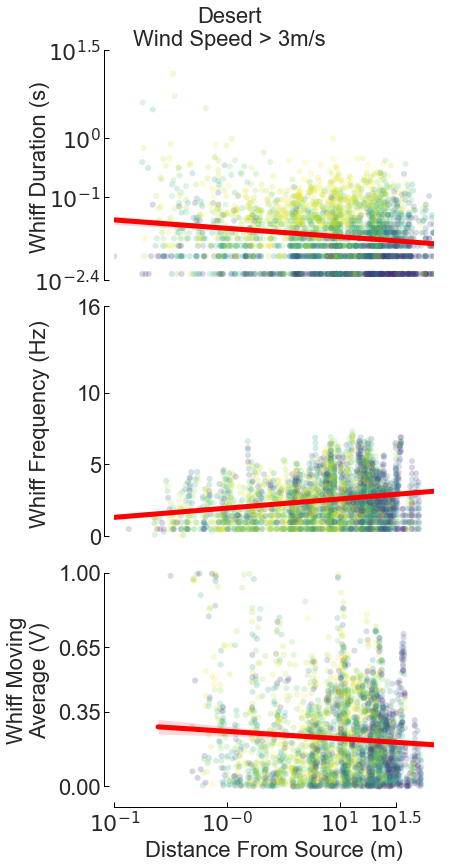

In [45]:
f,(ax1,ax2,ax3)=plt.subplots(3,1, figsize=(6,12))


var1 = ax1.scatter(fdf.log_dist_from_source, fdf.log_whiff, c=fdf.mean_concentration, cmap='viridis', 
            edgecolors='none', alpha=0.2, vmin=4, vmax=10)
ax1.grid(False)
g1 =sns.regplot(x="log_dist_from_source",y="log_whiff", data=fdf, 
            ax=ax1, color='r', line_kws={'color':'red','linewidth':5}, scatter=False, truncate=True)
g1.set(xlabel=None, ylabel=None)

ax1.set_ylabel('Whiff Duration (s)')
mpl_functions.adjust_spines(ax1,['left'],
                            spine_locations={}, 
                            smart_bounds=True,
                           
                            yticks=[-2.4,-1,0,1.5],
                            linewidth=1)
ax1.yaxis.set_label_coords(-0.2, 0.5)
ax1.set_yticklabels([r'$10^{-2.4}$',r'$10^{-1}$', r'$10^0$', r'$10^{1.5}$'])

# divider = make_axes_locatable(ax1)
# cax1 = divider.append_axes('right', size='5%', pad=0.08)
# cbar1=f.colorbar(var1, cax=cax1, orientation = 'vertical', ticks=[4, 10])
# cbar1.ax.set_yticklabels(['4', '10'])

########## subplot 1 #############

var2 = ax2.scatter(fdf.log_dist_from_source, fdf.mean_ef, c=fdf.mean_concentration, cmap='viridis', 
            edgecolors='none', alpha=0.2, vmin=4, vmax=10)
ax2.grid(False)
g2 = sns.regplot(x="log_dist_from_source",y="mean_ef", data=fdf, 
            ax=ax2, color='r', line_kws={'color':'red','linewidth':5}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)
# ax2.set_xlabel('Distance From Source (m)')
ax2.set_ylabel('Whiff Frequency (Hz)')

mpl_functions.adjust_spines(ax2,['left'],
                            spine_locations={}, 
                            smart_bounds=True,
                            
                            yticks=[0,5,10,16],
                            linewidth=1)
ax2.yaxis.set_label_coords(-0.2, 0.5)

# divider = make_axes_locatable(ax2)
# cax2 = divider.append_axes('right', size='5%', pad=0.08)
# cbar2=f.colorbar(var2, cax=cax2, orientation = 'vertical', ticks=[4, 10])
# cbar2.ax.set_yticklabels(['4', '10'])


########## subplot 2 #############

var3 = ax3.scatter(fdf.log_dist_from_source, fdf.mean_ma, c=fdf.mean_concentration, cmap='viridis', 
                   edgecolors='none', alpha=0.2, vmin=4, vmax=10)
ax3.grid(False)
g3=sns.regplot(x="log_dist_from_source",y="mean_ma", data=fdf, 
            ax=ax3, color='r', line_kws={'color':'red','linewidth':5}, scatter=False, truncate=False)
g3.set(xlabel=None, ylabel=None)
ax3.set_xlabel('Distance From Source (m)')
ax3.set_ylabel('Whiff Moving\nAverage (V)')
mpl_functions.adjust_spines(ax3,['left','bottom'],
                            spine_locations={}, 
                            smart_bounds=True,
                            xticks=[-1,0 , 1,1.5],
                            yticks=[0,0.35,0.65,1],
                            linewidth=1)
ax3.yaxis.set_label_coords(-0.2, 0.5)
ax3.set_xticklabels([r'$10^{-1}$',r'$10^{-0}$', r'$10^1$', r'$10^{1.5}$'])
# divider = make_axes_locatable(ax3)
# cax3 = divider.append_axes('right', size='5%', pad=0.08)
# cbar3=f.colorbar(var3, cax=cax3, orientation = 'vertical', ticks=[4, 10])
# cbar3.ax.set_yticklabels(['4', '10'])
# cbar3.ax.set_ylabel('Odor(V)', rotation=90)


########## subplot 3 #############

f.suptitle("Desert\nWind Speed > 3m/s")
f.tight_layout(pad=1)
figurefirst.mpl_functions.set_fontsize(f, 22)

# f.savefig('../../Figure/logHWStat.jpeg', dpi=300, bbox_inches = "tight")

In [63]:
# fdf = pd.read_hdf(dir+'ForestStats.h5')

In [65]:
# fdf = osm.sort_by_distance(fdf)

In [11]:
logwhiff=smf.ols(formula=' avg_dist_from_source ~ log_whiff', data=fdf).fit()
ef=smf.ols(formula=' avg_dist_from_source ~ mean_ef', data=fdf).fit()
ma=smf.ols(formula=' avg_dist_from_source ~ mean_ma', data=fdf).fit()
# logblank=smf.ols(formula=' avg_dist_from_source ~ log_blank', data=fdf).fit()

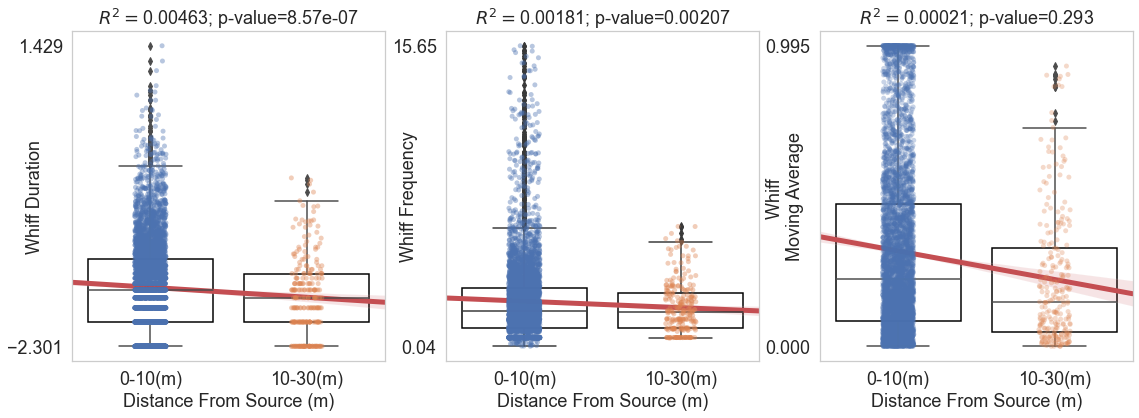

In [70]:
f, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(16,6)
                    ,gridspec_kw={'width_ratios': [1,1,1]})
## Log(Lenght of Whiffs)
sns.boxplot(x="distance_from_source_bin", y="log_whiff", 
            data=fdf,  dodge=True,  ax=ax1 )
boxplotfill(ax1)

ax1.yaxis.set_label_coords(-0.09, 0.5)
ax2.yaxis.set_label_coords(-0.09, 0.5)
ax3.yaxis.set_label_coords(-0.05, 0.5)
sns.stripplot(x="distance_from_source_bin", y="log_whiff", 
            data=fdf, dodge='True', ax=ax1, alpha=0.4)
sns.regplot(x="bins_distance",y="log_whiff", data=fdf, 
            ax=ax1, color='r', line_kws={'linewidth':5}, scatter=False, truncate=False)

ax1.grid(False)
ax1.set_xlabel('Distance From Source (m)')
ax1.set_ylabel('Whiff Duration')
ax1.set_title('$R^2=$'+str(np.round(logwhiff.rsquared,5)) 
                   +'; p-value='+ str('{:.3g}'.format(logwhiff.pvalues.log_whiff)))
ax1.set_yticks([fdf.log_whiff.min(),fdf.log_whiff.max()])

## Whiff Frequency
sns.boxplot(x="distance_from_source_bin", y="mean_ef", 
            data=fdf,  dodge=True,  palette='viridis',ax=ax2 )
boxplotfill(ax2)    
sns.stripplot(x="distance_from_source_bin", y="mean_ef", 
            data=fdf, dodge='True', ax=ax2, alpha=0.4)
sns.regplot(x="bins_distance",y="mean_ef", data=fdf, 
            ax=ax2, color='r', line_kws={'linewidth':5}, scatter=False, truncate=False)

ax2.grid(False)
ax2.set_xlabel('Distance From Source (m)')
ax2.set_ylabel('Whiff Frequency')
ax2.set_yticks([fdf.mean_ef.min(),fdf.mean_ef.max()])
ax2.set_title('$R^2=$'+str(np.round(ef.rsquared,5)) 
                   +'; p-value='+ str('{:.3g}'.format(ef.pvalues.mean_ef)))

#Intermittency Factor
sns.stripplot(x="distance_from_source_bin", y="mean_ma", 
            data=fdf, dodge='True', ax=ax3, alpha=0.3)
sns.boxplot(x="distance_from_source_bin", y="mean_ma", 
            data=fdf,  dodge=True, ax=ax3 )
boxplotfill(ax3)
sns.regplot(x="bins_distance",y="mean_ma", data=fdf, 
            ax=ax3, color='r', line_kws={'linewidth':5}, scatter=False, truncate=False)

ax3.grid(False)
ax3.set_yticks([fdf.mean_ma.min(),fdf.mean_ma.max()])
ax3.set_xlabel('Distance From Source (m)')
ax3.set_ylabel('Whiff \nMoving Average')
ax3.set_title('$R^2=$'+str(np.round(ma.rsquared,5)) 
            +'; p-value='+ str('{:.3g}'.format(ma.pvalues.mean_ma)))

# f.suptitle("Forest Odor Statistics")
f.tight_layout(pad=2)
figurefirst.mpl_functions.set_fontsize(f, 18)

# f.savefig('../../Figure/MA_1_HWlog.jpeg', dpi=300)
# f.savefig('../../Figure/OdorStatForest.jpeg', dpi=300, bbox_inches = "tight")

In [29]:
whiff_frequency=smf.ols(formula='mean_ef ~ np.abs(fdf.avg_perpendicular_encounter) + np.abs(fdf.avg_parallel_encounter)', data=fdf).fit()
whiff_duration=smf.ols(formula='log_whiff~ np.abs(fdf.avg_perpendicular_encounter) + np.abs(fdf.avg_parallel_encounter)', data=fdf).fit()
moving_avg = smf.ols(formula='mean_ma ~ np.abs(fdf.avg_perpendicular_encounter) + np.abs(fdf.avg_parallel_encounter)', data=fdf).fit()

In [30]:
fdf['whiff_frequency_resid']=whiff_frequency.resid
fdf['whiff_duration_resid'] = whiff_duration.resid
fdf['moving_avg_resid'] = moving_avg.resid

In [66]:
# whiffresid=smf.ols(formula=' avg_dist_from_source ~ encounter_resid', data=fdf).fit()
# efresid=smf.ols(formula=' avg_dist_from_source ~ encounterfreq_resid', data=fdf).fit()
# maresid=smf.ols(formula=' avg_dist_from_source ~ intermittencyfact_resid', data=fdf).fit()
# logblankresid=smf.ols(formula=' avg_dist_from_source ~ intermittency_resid', data=fdf).fit()

In [33]:
distance_adjusted=smf.ols(formula='avg_dist_from_source ~ whiff_frequency_resid + whiff_duration_resid + moving_avg_resid', data=fdf).fit()
print(distance_adjusted.summary())

                             OLS Regression Results                             
Dep. Variable:     avg_dist_from_source   R-squared:                       0.043
Model:                              OLS   Adj. R-squared:                  0.042
Method:                   Least Squares   F-statistic:                     42.22
Date:                  Thu, 10 Feb 2022   Prob (F-statistic):           1.09e-26
Time:                          10:04:07   Log-Likelihood:                -10782.
No. Observations:                  2842   AIC:                         2.157e+04
Df Residuals:                      2838   BIC:                         2.160e+04
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept 

In [34]:
distance=smf.ols(formula='avg_dist_from_source ~ mean_ef + log_whiff + mean_ma ', data=fdf).fit()
print(distance.summary())

                             OLS Regression Results                             
Dep. Variable:     avg_dist_from_source   R-squared:                       0.039
Model:                              OLS   Adj. R-squared:                  0.038
Method:                   Least Squares   F-statistic:                     38.23
Date:                  Thu, 10 Feb 2022   Prob (F-statistic):           3.24e-24
Time:                          10:04:10   Log-Likelihood:                -10788.
No. Observations:                  2842   AIC:                         2.158e+04
Df Residuals:                      2838   BIC:                         2.161e+04
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.3773      0.843

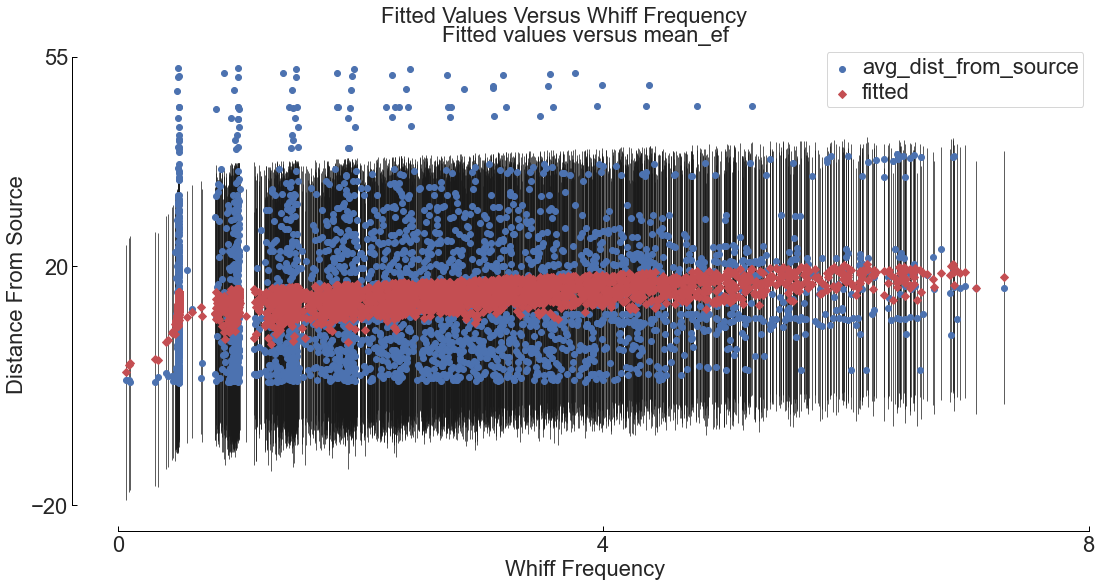

In [53]:
f,ax=plt.subplots(1,1,figsize=(15,8)) 
mod = sm.graphics.plot_fit(distance, "mean_ef", ax=ax)
ax.set_xlabel('Whiff Frequency')
ax.set_ylabel('Distance From Source')
ax.grid(False)
mpl_functions.adjust_spines(ax,['left','bottom'],
                            spine_locations={}, 
                            smart_bounds=True,
                            xticks=[0,4,8],
                            yticks=[-20,20,55],
                            linewidth=1)


f.suptitle("Fitted Values Versus Whiff Frequency")
f.tight_layout(pad=1)
figurefirst.mpl_functions.set_fontsize(f, 22)


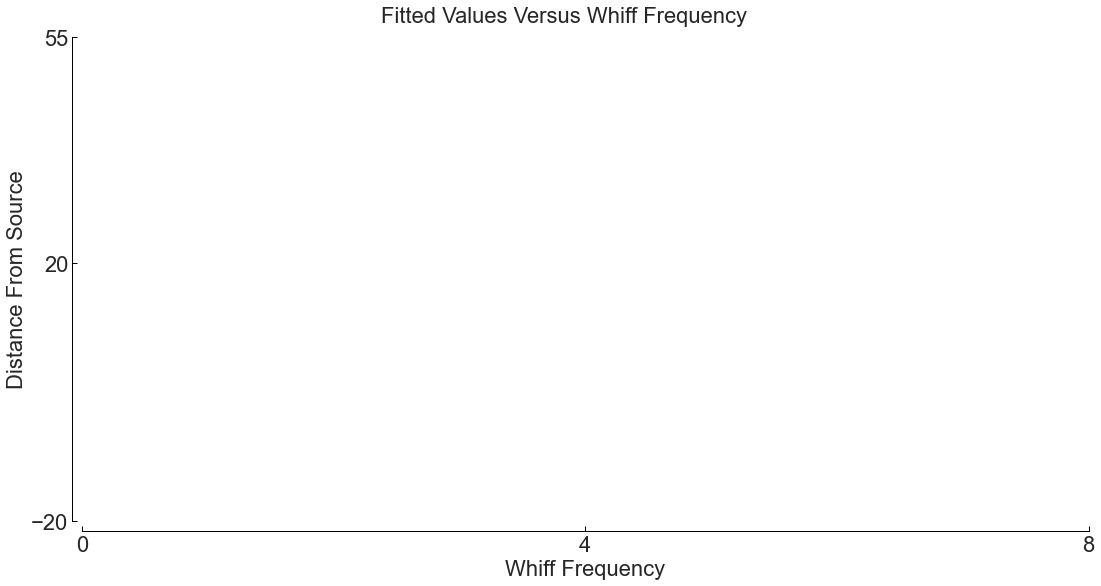

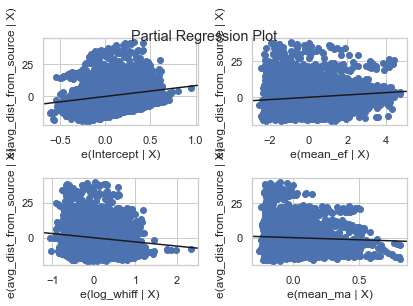

In [59]:
f,ax=plt.subplots(1,1,figsize=(15,8)) 
sm.graphics.plot_partregress_grid(distance)
ax.set_xlabel('Whiff Frequency')
ax.set_ylabel('Distance From Source')
ax.grid(False)
mpl_functions.adjust_spines(ax,['left','bottom'],
                            spine_locations={}, 
                            smart_bounds=True,
                            xticks=[0,4,8],
                            yticks=[-20,20,55],
                            linewidth=1)


f.suptitle("Fitted Values Versus Whiff Frequency")
f.tight_layout(pad=1)
figurefirst.mpl_functions.set_fontsize(f, 22)



In [ ]:
# ## BootStrapping Results for Distance ~ Odor Statistics

# sns.set_style('whitegrid')
# f, ((ax1,ax2,ax3,ax4)) = plt.subplots(4,1, figsize=(16,14))
# ax1.plot(rdf.angles,rdf.rsquared)
# ax1.set_yticks([rdf.rsquared.min(), rdf.rsquared.max()])
# ax1.set_ylabel('$R^2$', rotation = 0, color='blue')
# set_grid_false(ax1)
# ax1.yaxis.set_label_coords(-0.04,0.45)
# ax1.axes.get_xaxis().set_visible(False)

# ax2.plot(rdf.angles,rdf.p_whiff_length)
# ax2.set_yticks([rdf.p_whiff_length.min(), rdf.p_whiff_length.max()])
# ax2.set_ylabel('$p-value$\nWhiff Duration', rotation = 0, color='blue')
# set_grid_false(ax2)
# ax2.yaxis.set_label_coords(-0.08,0.4)
# ax2.axes.get_xaxis().set_visible(False)

# ax3.plot(rdf.angles, rdf.p_encounter_frequency)
# ax3.set_yticks([rdf.p_encounter_frequency.min(),rdf.p_encounter_frequency.max()])
# ax3.set_ylabel('$p-value$\nEncounter Frequency', rotation = 0, color='blue')
# set_grid_false(ax3)
# ax3.yaxis.set_label_coords(-0.1,0.4)
# ax3.axes.get_xaxis().set_visible(False)

# ax4.plot(rdf.angles, rdf.p_moving_avg)
# ax4.set_yticks([rdf.p_moving_avg.min(),rdf.p_moving_avg.max()])
# ax4.set_xticks([45, 50, 55, 60, 65, 70, 75, 80, 85, 90])
# ax4.set_ylabel('$p-value$\nMoving Average', rotation = 0, color='blue')
# set_grid_false(ax4)
# ax4.yaxis.set_label_coords(-0.08,0.4)
# ax4.set_xlabel('Change in Direction', color='blue')

# f.suptitle('Wind Speed < 3m/s\nDistance ~ Odor-Statistics', fontsize='medium')
# f.tight_layout(pad=4)
# figurefirst.mpl_functions.set_fontsize(f, 18)
# # f.savefig('../../Figure/changeInDirNotWindy.jpeg', dpi=1000) 
# # f.savefig('../../Figure/removeddisc.svg', format='svg',dpi=1200)